In [3]:
import pandas as pd
import numpy as np
import wrds
import datetime
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.linear_model import LinearRegression

In [4]:
class Momentum:
    def __init__(self, data, ranking_period, holding_period):
        # basic data preprocessing
        # Using groupby().first().unstack().T can construct a dataframe with columns as stock symbols and index as date.
        self.data = data
        self.ret = data.groupby(['permno', 'date']).ret.first().unstack().T
        self.vol = data.groupby(['permno', 'date']).vol.first().unstack().T
        self.price = np.abs(data.groupby(['permno', 'date']).prc.first().unstack().T)
        self.shrout = data.groupby(['permno', 'date']).shrout.first().unstack().T
        self.market_cap = self.price.multiply(self.shrout)
        self.ranking_period = ranking_period
        self.holding_period = holding_period

    def sign_weight(self, x):
        # 1 means long and -1 means short.
        if (x <= 0.1) & (x > 0):
            return -1
        elif x >= 0.9:
            return 1
        else:
            return 0

    def daily_momentum(self):
        # this function can produce daily momentum dataframe.

        momentum = (self.ret.add(1).cumprod().shift(20) / self.ret.add(1).cumprod().shift(self.ranking_period)).rank(
            axis=1, pct=True).dropna(axis=0, how='all')  # We need to exclude the recent month.

        # Exclude the penny stocks and exclude small market capital stocks.
        momentum = momentum[(self.price > 5) & (self.market_cap.rank(axis=1, pct=True) > .2)]
        return momentum

    def signal_generation(self):
        momentum = self.daily_momentum()

        # Sign the trading weight.
        momentum_signal = momentum.apply(lambda x: x.apply(lambda x: self.sign_weight(x))).dropna(axis=0, how='all')

        # Using resample function to get the signal for the end of every N months. (N month is the holding period)
        temp = momentum_signal.resample(self.holding_period).last()

        # Construct a new dataframe to put resample signal in it.
        trading_signal = pd.DataFrame(index=momentum_signal.index, columns=momentum_signal.columns)
        for i in temp.index[:-1]:
            if i in trading_signal.index:
                trading_signal.loc[i] = temp.loc[i]
            # There may be some time, the end of 1 month is not a trading day.
            # Then we just find the closest trading day after it to rebalance.
            else:
                temp_value = temp.loc[i]
                while i not in trading_signal.index:
                    i += datetime.timedelta(days=1)
                trading_signal.loc[i] = temp_value

        # The trading signal should be the same in 1 holding period.
        trading_signal.fillna(method='ffill', inplace=True)
        trading_signal.dropna(inplace=True)
        return trading_signal

    def portfolio_generation(self, value_weighted=False):

        trading_signal = self.signal_generation()
        winner_portfolio = trading_signal[trading_signal == 1.]
        loser_portfolio = trading_signal[trading_signal == -1.]

        if not value_weighted:
            ret_winner = winner_portfolio.multiply(self.ret).mean(axis=1)
            ret_loser = loser_portfolio.multiply(self.ret).mean(axis=1)
        else:
            # Using the value weighted. (Market Capital Weighted Average)
            weighted_cap = self.market_cap[trading_signal != 0]
            weight = weighted_cap.div(weighted_cap.sum(axis=1), axis='rows')
            ret_winner = winner_portfolio.multiply(weight).multiply(self.ret).sum(axis=1)
            ret_loser = loser_portfolio.multiply(weight).multiply(self.ret).sum(axis=1)

        # This function will return the raw return of everyday.
        return ret_winner, ret_loser

    def volatility_weighted(self, ret_winner, ret_loser):

        original_return = ret_winner + ret_loser
        # Adjust the portfolio weight with volatility.
        volatility = original_return.apply(lambda x: x ** 2).rolling(126, min_periods=126).mean() * 21
        volatility_weight = volatility.apply(lambda x: 0.12 / (x ** 0.5 * (12 ** 0.5)))

        # Draw a graph of volatility weight.
        volatility_weight.plot(kind='line')
        plt.show()

        new_volatility_weight = pd.Series(index=volatility_weight.index)

        # This part is similar to signal generation part.
        # Because the volatility weight will be the same in one holding period.
        temp = volatility_weight.resample(self.holding_period).last()
        for i in temp.index[:-1]:
            if i in new_volatility_weight.index:
                new_volatility_weight.loc[i] = temp.loc[i]
            else:
                t = temp.loc[i]
                while i not in new_volatility_weight.index:
                    i += datetime.timedelta(days=1)
                new_volatility_weight.loc[i] = t
        new_volatility_weight.fillna(method='ffill', inplace=True)
        return new_volatility_weight.shift(1).multiply(original_return)

In [5]:
# loading data

conn = wrds.Connection()
data = conn.raw_sql("""
                      select a.permno, a.date, 
                      b.shrcd, b.exchcd,
                      a.ret, a.vol, a.shrout, a.prc
                      from crsp.dsf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/2014' and '12/31/2018' 
                      and b.exchcd between 1 and 1
                      and b.shrcd between 10 and 11
                      """)
data.date = pd.to_datetime(data.date)

Enter your WRDS username [tt]:hengbo
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


# Application Examples

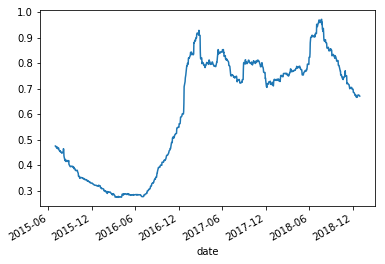

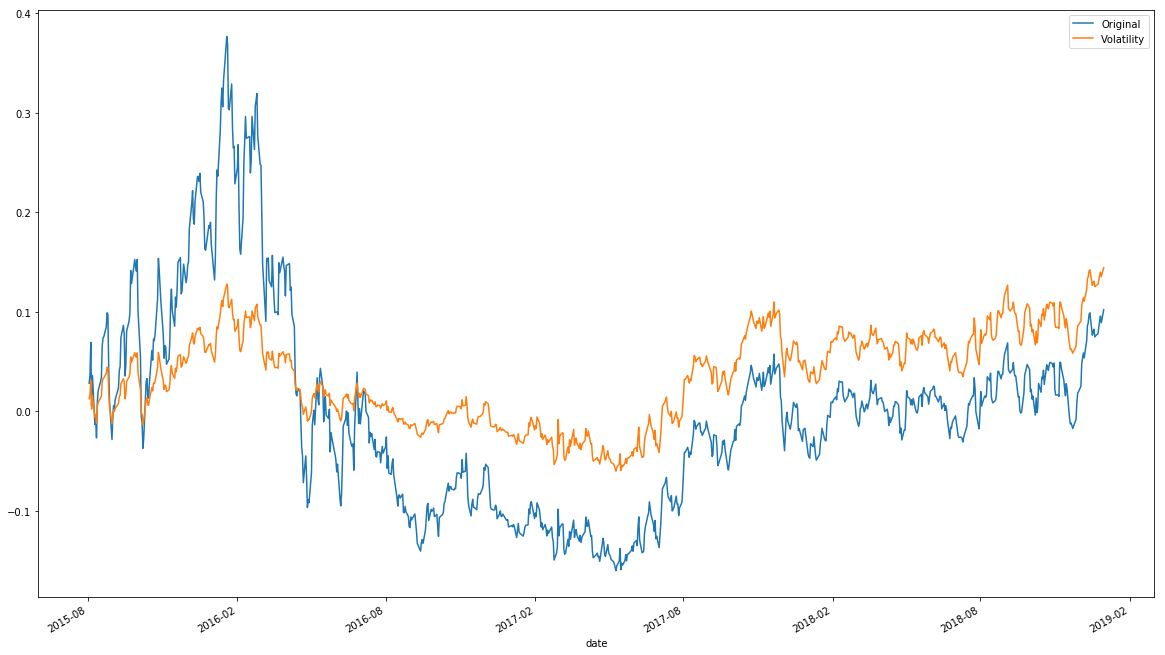

In [6]:
# Construct a class.
a = Momentum(data, 240, '1M')

# Get the daily momentum data
daily_momentum = a.daily_momentum()

# Get the winner and loser daily return.
ret1, ret2 = a.portfolio_generation(False)

# Get the volatility adjusted return.
vol_ret = a.volatility_weighted(ret1, ret2)

# Draw return graphs. You can do as you want.
plt.figure(figsize=(20, 12))
(ret1 + ret2).loc[vol_ret.dropna().index].cumsum().plot(kind='line', label='Original')
vol_ret.cumsum().plot(kind='line', label='Volatility')
plt.legend()
plt.show()

In [7]:

def mu_WML(r,r_portfolio): #input is pd.Series of market return and portfolio return with at least past 2 years
    ib = r - r.shift(252*2)
    ib = [1 if x<=0 else 0 for x in ib] #indicator of bear market: if 24month return is <=0
    sig = r.rolling(126).var() ##variance of market return of last 126 days
    IB = np.array(ib[252*2:])
    SIG = sig.to_numpy()[252*2:]
    data = np.concatenate((IB[:, np.newaxis], SIG[:, np.newaxis]),axis = 1 )
    reg = LinearRegression().fit(data, r_portfolio.iloc[-len(IB):]) #[-len(IB):] is used to match the length
    return reg

def sigma2(r_portfolio): #pd.Series of portfolio return
    am = arch_model(r_portfolio, p=1, o=1, q=1)
    res = am.fit(update_freq=5)
    #https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html
    return(res)

def weight(r, r_portfolio,lambda_): #input is pd.Series of market return and portfolio return with at least past 2 years
    model_mu = mu_WML(r,r_portfolio)    #data on trading day should not be included
    model_sig = sigma2(r_portfolio)
    ib = r.iloc[-1] - r.iloc[-252*2]
    sig = r.iloc[-252:].var()
    mu_t = model_mu.predict(np.array([[ib,sig]]))
    forecasts = model_sig.forecast(horizon = 5)
    sigma2_t = forecasts.variance.iloc[-1].var()

    print(mu_t,sigma2_t)
    return((1/(2*lambda_))*mu_t/sigma2_t)
    

In [8]:
market = conn.raw_sql("""
                      select DATE,vwretd
                      from crsp.dsi
                      where DATE between '01/01/2014' and '12/31/2010'
                      """)
market.index = pd.to_datetime(market.index)

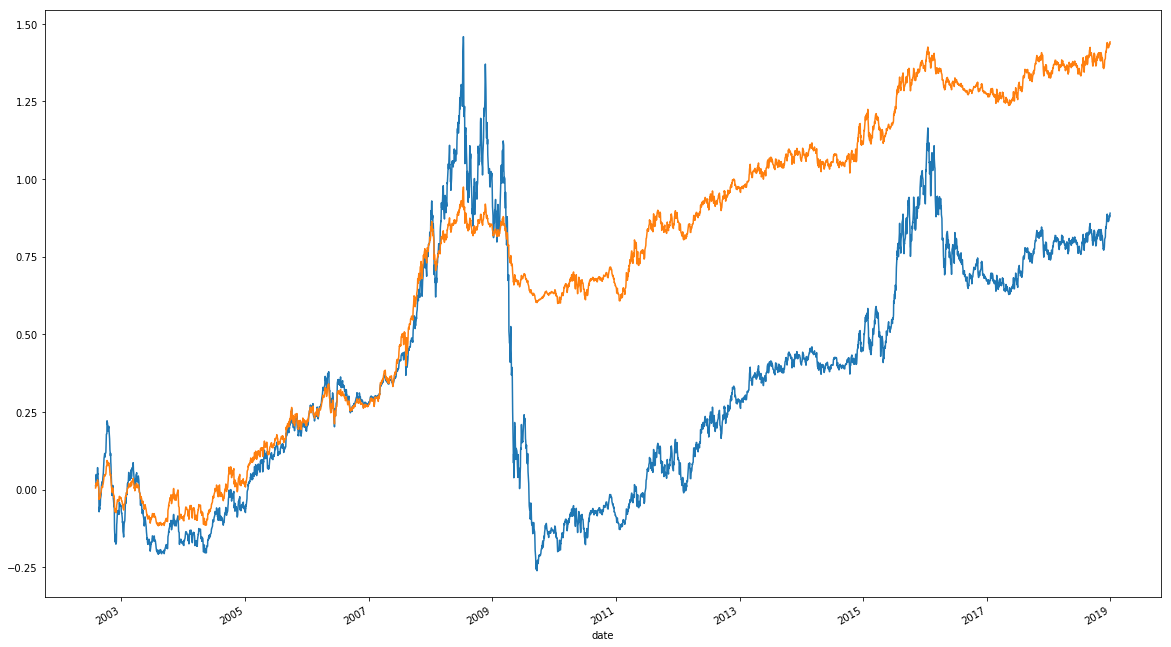

In [31]:
plt.figure(figsize=(20,12))
(ret1+ret2).loc[vol_ret.dropna().index].cumsum().plot(kind='line')
vol_ret.cumsum().plot(kind='line')
#plt.yscale('log')